goal:

- use librosa on 1000 audio files and/or 50 class folders minimum
- store information in a dataframe (excluding actual file data for now)
  - folder name, file name, sampling rate, data length, file length, file size(?)

In [1]:
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio
import copy
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from tqdm import tqdm
from IPython.display import Audio

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from imblearn.over_sampling import RandomOverSampler

from math import floor

import sys

In [2]:
# experimental parameters for model training, for simple configuration in a single cell.
# very useful for reporting spreadsheet

split_interval_secs = 2.5
sample_rate = 32000

total_folders = 50
min_rating = 5.0
max_files_per_folder = -1

sampling_technique = "median"

test_size = 0.2

epochs = 500
batch_size = 1024
dropout_rate = 0
learning_rate = 0.001
momentum = 0
experimental = False

In [3]:
def reset_seed():
    torch.manual_seed(1368)
    random.seed(1368)
    np.random.seed(1368)

reset_seed()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).total_memory)

print(device)
print(torch.cuda.get_device_name())

8546353152
cuda
NVIDIA GeForce RTX 5060


In [5]:
def get_random_folders_filtered(base_dir: str, split_interval_secs: float, sample_rate: int = 32000, total_folders: int = 50, max_files_per_folder: int = -1, min_rating: float = 4.0):
    # base_dir: directory of all the audio file folders
    # split_interval_secs: the length of each sound clip when split up in a file.
    #   - final dataframe will not contain any sound clips over/under this length
    # sample_rate: sample rate of sound clips in hz
    # total_folders: total folders to iterate through the files, given range of files per folder
    # min_files_per_folder: minimum files to exist in the folder
    # max_files_per_folder: maximum files to use inside the folder

    # get the list of valid folders and files to analyse
    folders = []
    valid_folders = set()
    valid_files = set([l.replace("\n", "") for l in open(f"rating_thresholds_at_least_10_classes/min_rating_{int(min_rating * 2)}.txt").readlines()])
    for f in valid_files: valid_folders.add(f.split("/")[0])
    for folder in [line.replace("\n", "") for line in open("folder_order.txt").readlines()]:
        if folder in valid_folders:
            folders.append(folder)

    folder_count = 0

    # if there are less folders than those specified, view all folders instead of given amount
    total_folders = min(len(folders), total_folders)
    split_length = 10000000000000 # absurd number for future use

    rows = []
    
    for folder in folders:
        folder_path = base_dir + folder + "/"
        valid_folder_files = []
        # only iterate through the valid audio files
        for file in os.listdir(folder_path):
            if folder + "/" + file in valid_files:
                valid_folder_files.append(folder_path + file)
        random.shuffle(valid_folder_files)

        if max_files_per_folder > 0:
            valid_folder_files = valid_folder_files[:min(max_files_per_folder, len(valid_folder_files))]

        # iterate through each file in the folder
        for file_path in (progress_bar := tqdm(valid_folder_files)):
            # load file data and resample to sample_rate if necessary
            file_data, file_sample_rate_hz = torchaudio.load(uri=file_path, channels_first=True)
            if file_sample_rate_hz != sample_rate:
                file_data = torchaudio.functional.resample(file_data, orig_freq=file_sample_rate_hz, new_freq=sample_rate)

            # convert all audio into mono (1 channel) if audio is stereo (2 channels)
            if file_data.shape[0] == 2:
                file_data = file_data.mean(dim=0)
            else:
                file_data = file_data.flatten()

            # get total number of X second splits
            total_splits = floor(len(file_data) / int(sample_rate * split_interval_secs))
            
            # convert file data into mel-spectrogram fourier transform for feeding into CNN
            n_fft = 1024

            mel_spec_transform = torchaudio.transforms.MelSpectrogram(sample_rate = sample_rate, power=2, n_fft=n_fft)
            amp_to_db_transform = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=80)
            mel_spec_data_db = amp_to_db_transform(mel_spec_transform(file_data))
            
            # if file is at least X seconds.
            if total_splits >= 1:
                split_length = min(mel_spec_data_db.shape[1] // total_splits, split_length)
                mel_spec_splits = np.arange(0, mel_spec_data_db.shape[1], split_length)
                for i in range(len(mel_spec_splits) - 1):
                    start = mel_spec_splits[i]
                    end = mel_spec_splits[i + 1]

                    mel_spec_split = mel_spec_data_db[:, start:end]

                    row = {}
                    row["folder"] = folder
                    row["file"] = file_path.split("/")[-1]
                    row["mel_spec"] = mel_spec_split
                    row["mel_spec_shape"] = mel_spec_split.shape

                    rows.append(row)

            progress_bar.set_description(f"Folder {folder_count + 1}/{total_folders} - {folder}")

        # end loop if total_folders has been reached
        folder_count += 1
        if folder_count >= total_folders: break

    # trim the ends of some mel spectrograms because of stupid floating point nonsense
    for row in rows:
        if row["mel_spec_shape"][1] != split_length:
            row["mel_spec"] = row["mel_spec"][:, :split_length]
            row["mel_spec_shape"] = row["mel_spec"].shape

    return pd.DataFrame(rows)

In [6]:
# base_dir = "/mnt/lustre/peprmint/train_audio/"
base_dir = "../datasets/birdsongs-combined/train_audio/"

reset_seed()

folder_df = get_random_folders_filtered(
    base_dir, 
    split_interval_secs=split_interval_secs, 
    sample_rate=sample_rate,
    total_folders=total_folders,
    min_rating=min_rating,
    max_files_per_folder=max_files_per_folder
)

Folder 50/50 - grycat: 100%|██████████| 56/56 [00:04<00:00, 13.35it/s]


In [7]:
folder_df["mel_spec_shape"].value_counts()

mel_spec_shape
(128, 156)    44565
Name: count, dtype: int64

In [8]:
folder_df["folder"].value_counts()

folder
redcro     5633
barswa     3786
spotow     2745
combuz1    2420
banswa     2112
compau     2051
combul2    1767
comyel     1673
grycat     1656
bkskit1    1540
eucdov     1468
logshr     1292
indbun      974
cubthr      892
rerswa1     875
litegr      769
brncre      764
scbwre1     756
yehbla      727
verdin      663
whiwre1     618
pirfly1     599
yehcar1     534
whbman1     518
oliwoo1     507
sheowl      491
leater1     481
cobtan1     469
annhum      402
brnjay      400
mitpar      392
buwwar      369
dowwoo      357
mawthr1     352
phaino      351
royter1     319
blhpar1     315
bkbmag1     305
peflov      299
amtspa      221
piebus1     219
ocbfly1     203
comloo      192
yebsap      191
amepip      182
lotduc      172
insowl1     171
blkfra      143
zebdov      137
brubru1      93
Name: count, dtype: int64

In [9]:
print("sound clips BEFORE any sampling:", len(folder_df))

sound clips BEFORE any sampling: 44565


In [10]:
len(folder_df["folder"].unique())

50

<Axes: title={'center': 'Value counts before over/under sampling.'}, xlabel='folder'>

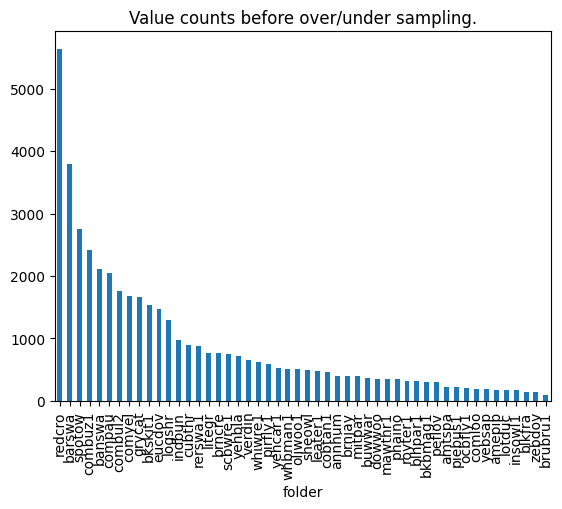

In [11]:
folder_df["folder"].value_counts().plot.bar(title="Value counts before over/under sampling.")

In [12]:
# apply random undersampling OR oversampling

reset_seed()

if sampling_technique == "under":
    # random "naive" undersampling
    # delete random rows from all classes except minority class(es)
    min_folder_count = min(folder_df["folder"].value_counts())

    indices_to_keep = np.array([])

    for f in folder_df["folder"].unique():
        indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=min_folder_count), indices_to_keep])

    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)

if sampling_technique == "over":
    ros = RandomOverSampler(random_state=1368)

    # print how much each class will increase by (relative to its current size)
    max_folder = max(folder_df["folder"].value_counts())
    for folder, count in folder_df["folder"].value_counts().sort_values(ascending=True).items():
        print(f"{folder} will increase by {round((max_folder / count - 1) * 100, 2)}%")

    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)
    # moves "folder" to other side of df but shouldn't affect anything

if sampling_technique == "median":
    # take the median value of folder counts
    # under sample all above the median
    # over smaple all below the median

    ros = RandomOverSampler(random_state=1368)
    median_folder_count = round(folder_df["folder"].value_counts().median())
    indices_to_keep = np.array([])

    print("median:", median_folder_count)

    for f in folder_df["folder"].unique():
        folder_length = len(folder_df[folder_df["folder"] == f])
        if folder_length > median_folder_count:
            indices_to_keep = np.concat([np.random.choice(folder_df[folder_df["folder"] == f].index, size=median_folder_count), indices_to_keep])
        else:
            indices_to_keep = np.concat([folder_df[folder_df["folder"] == f].index, indices_to_keep])
        
    folder_df = folder_df.loc[indices_to_keep]
    folder_df.reset_index(drop=True, inplace=True)
    
    folder_df = pd.concat(ros.fit_resample(folder_df.drop("folder", axis=1), folder_df["folder"]), axis=1)

median: 499


<Axes: title={'center': 'Value counts after median sampling.'}, xlabel='folder'>

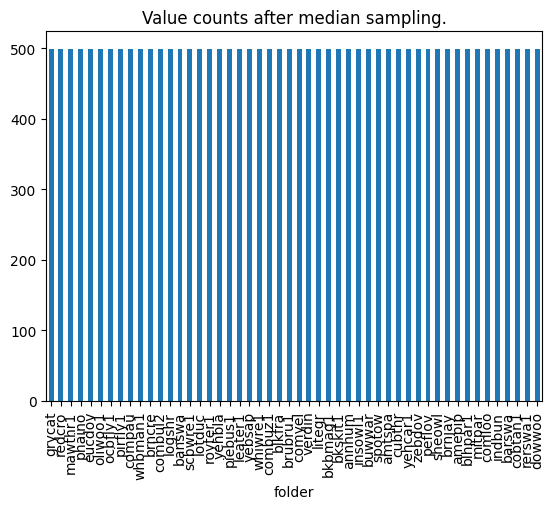

In [13]:
folder_df["folder"].value_counts().plot.bar(title=f"Value counts after {sampling_technique} sampling.")

In [14]:
print("sound clips AFTER sampling:", len(folder_df))

sound clips AFTER sampling: 24950


torch.Size([128, 156])


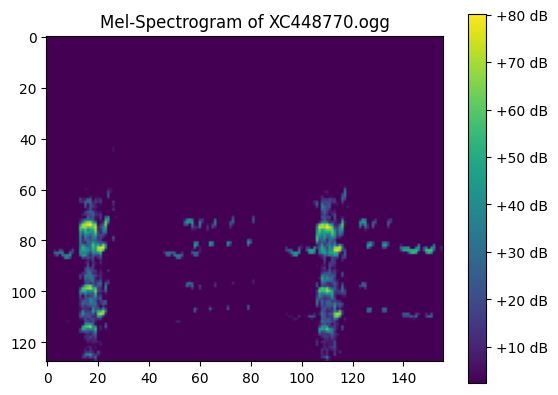

torch.Size([128, 156])


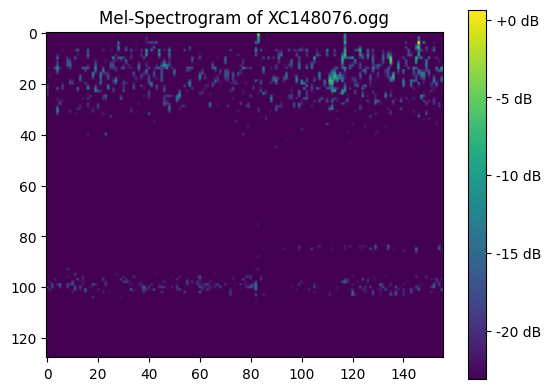

torch.Size([128, 156])


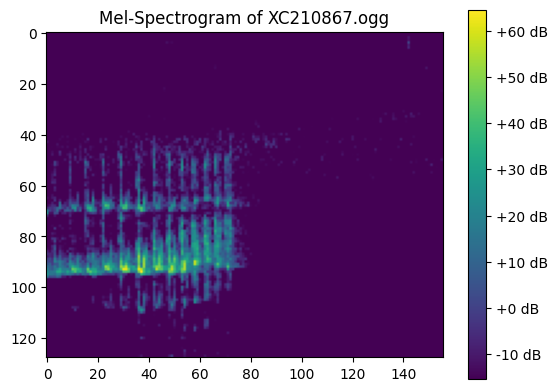

In [15]:
# plot 5 random mel spectrograms
# checks for consistency in scaling and whatnot

reset_seed()

sample_spec_indices = random.sample(folder_df.index.tolist(), k=3)

for i in sample_spec_indices:
    row = folder_df.iloc[i]
    
    print(row["mel_spec_shape"])
    
    plt.figure()
    plt.imshow(row["mel_spec"])
    plt.title(f"Mel-Spectrogram of {'/'.join(row['file'].split('/')[-2:])}")
    plt.colorbar(format='%+2.0f dB')
    plt.show()

del row

In [16]:
# input shape needs to be AxBxCxD
# A = list of files
# B = depth of each one (currently just 1, as it only contains 1 value. if colours are used then maybe up it to 3)
# CxD = input width/height (128x626 etc)

x = torch.from_numpy(np.stack(folder_df["mel_spec"].values))
x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
x = x.to(device)

le = LabelEncoder()
y = torch.LongTensor(le.fit_transform(folder_df["folder"]))
y = y.to(device)

In [17]:
reset_seed()

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=test_size, random_state=1368)

del x, y

In [18]:
# create machine learning model.

class TestModel(nn.Module):
    global folder_df

    def __init__(self, input_shape: torch.Size, dropout_rate: float = 0):
        super().__init__()

        total_output_classes = len(folder_df["folder"].unique())

        # input shape should be some list/tuple of length 4
        if len(input_shape) != 4: return Exception("Input shape is not AxBxCxD.")

        # define layers here
        # assuming input shape = 1x1x128x126 = AxBxCxD

        # conv2d: 1x128x126 -> 1x124x124 (kernel size = (5,3))
        # relu
        # max pool: 1x124x124 -> 1x62x62 (pool size = (2,2))
        # conv2d: 1x62x62 -> 1x60x60 (kernel size = (3, 3))
        # relu
        # max pool: 1x60x60 -> 1x30x30 (pool size = (2, 2))
        # flatten: 1x30x30 -> 900
        # linear: 900 -> 128
        # linear: 128 -> 32
        # linear: 32 -> (output layers)

        A = input_shape[0]
        B = input_shape[1]
        C = input_shape[2]
        D = input_shape[3]

        self.conv1 = nn.Conv2d(in_channels=B, out_channels=1, kernel_size=(5, 3)) # output shape = Ax1x(C-4)x(D-2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) # output shape = Ax1x(C-4 // 2)x(D-2 // 2)
        self.drop1 = nn.Dropout(p=dropout_rate)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(3, 3)) # output shape = Ax1x(C - 4 // 2 - 2)x(D - 2 // 2 - 2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2) # output shape = Ax1x([(C - 4) // 2 - 2] // 2)x([(D - 2) // 2] - 2] // 2) idk the bracket order
        self.drop2 = nn.Dropout(p=dropout_rate)
        self.flat = nn.Flatten()

        flatten_nodes = ((((C - 4) // 2) - 2) // 2) * ((((D - 2) // 2) - 2) // 2)
        
        self.linear1 = nn.Linear(in_features=flatten_nodes, out_features=128)
        self.linear2 = nn.Linear(in_features=128, out_features=32) 
        self.output = nn.Linear(in_features=32, out_features=total_output_classes)

    def forward(self, x):
        # define calculations here
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.drop1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        x = self.drop2(x)
        x = self.flat(x)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.output(x)

        return x

In [19]:
# model: the model to train
# loss_fn: the loss function to update weights
# optimizer: the optimiser function to affect rate of change
# epochs: number of epochs to train the model over
# batch_size: samples to train x_train and y_train to avoid memory issues
# save_best_to_file: save model with highest test accuracy to models/ folder.
# experimental: whether to end training after 5 consecutive runs of no higher test accuracy.
#       - training ends when either [epochs] epochs have been run, *OR* if 5 consecutive runs do not improve test accuracy from previous best.

def train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file = False, experimental = False):
    global x_train, y_train
    batch_indices = np.linspace(0, len(x_train), int(len(x_train) / batch_size), dtype="int")

    train_loss_hist = []
    train_acc_hist = []
    test_acc_hist = []

    best_test_acc = 0
    best_model = None

    experimental_counter = 0

    for epoch in range(1, epochs + 1):
        model.train()

        train_acc = 0
        
        for i in range(len(batch_indices) - 1):
            start_index = batch_indices[i]
            stop_index = batch_indices[i + 1]

            x_batch = x_train[start_index:stop_index]
            y_batch = y_train[start_index:stop_index]

            x_batch, y_batch = shuffle(x_batch, y_batch)

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            train_acc += sum(torch.argmax(y_pred, dim=1) == y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_acc = train_acc * 100 / len(y_train)

        model.eval()
        test_acc = sum(torch.argmax(model(x_test), dim=1) == y_test) * 100 / len(y_test)

        print(f"Epoch {epoch}: train loss = {loss:.04f}, train acc = {train_acc:.02f}%, test acc = {test_acc:.02f}% {"!!" if test_acc > best_test_acc else ""}")

        train_loss_hist.append(float(loss.cpu().detach().numpy()))
        train_acc_hist.append(float(train_acc.cpu().detach().numpy()))
        test_acc_hist.append(float(test_acc.cpu().detach().numpy()))

        if experimental:
            experimental_counter += 1

        if test_acc > best_test_acc:
            experimental_counter = 0
            best_test_acc = test_acc
            
            # overwrite best model with new best model
            best_model = copy.deepcopy(model.state_dict())

        if experimental_counter == 5:
            print("Experimental Mode ended the training early, as the testing accuracy had not increased over 5 consecutive epochs.")
            break
        
    if save_best_to_file:
        model_save_path = "models/"
        if not os.path.exists(model_save_path): os.mkdir(model_save_path)
        file_number = len(os.listdir(model_save_path)) + 1
        file_name = f"best_model_{file_number:>03}"
        best_model_path = model_save_path + file_name + ".pth"

        torch.save(best_model, best_model_path)

    plt.figure(figsize=(12,8))
    pd.Series(train_acc_hist).plot.line(label="Train", color="blue")
    pd.Series(test_acc_hist).plot.line(label="Test", color="red")
    plt.legend()
    plt.ylim((0, 100))
    plt.yticks(np.arange(0, 101, 10))
    plt.title(f"Convolutional Neural Network on {len(folder_df)} sound clips over {len(folder_df["folder"].unique())} folders.")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.grid(axis="y")
    plt.show()

    return train_loss_hist, train_acc_hist, test_acc_hist, best_model

Epoch 1: train loss = 3.4974, train acc = 8.34%, test acc = 11.76% !!
Epoch 2: train loss = 3.1196, train acc = 17.60%, test acc = 18.50% !!
Epoch 3: train loss = 2.8742, train acc = 24.75%, test acc = 23.61% !!
Epoch 4: train loss = 2.6746, train acc = 30.96%, test acc = 27.35% !!
Epoch 5: train loss = 2.5224, train acc = 35.10%, test acc = 29.78% !!
Epoch 6: train loss = 2.3985, train acc = 38.90%, test acc = 31.54% !!
Epoch 7: train loss = 2.2962, train acc = 41.22%, test acc = 31.92% !!
Epoch 8: train loss = 2.2111, train acc = 43.47%, test acc = 32.93% !!
Epoch 9: train loss = 2.1383, train acc = 45.51%, test acc = 33.91% !!
Epoch 10: train loss = 2.0735, train acc = 47.36%, test acc = 34.63% !!
Epoch 11: train loss = 2.0159, train acc = 48.86%, test acc = 35.43% !!
Epoch 12: train loss = 1.9609, train acc = 50.34%, test acc = 36.09% !!
Epoch 13: train loss = 1.9109, train acc = 51.78%, test acc = 36.37% !!
Epoch 14: train loss = 1.8700, train acc = 52.77%, test acc = 36.85% !!
Ep

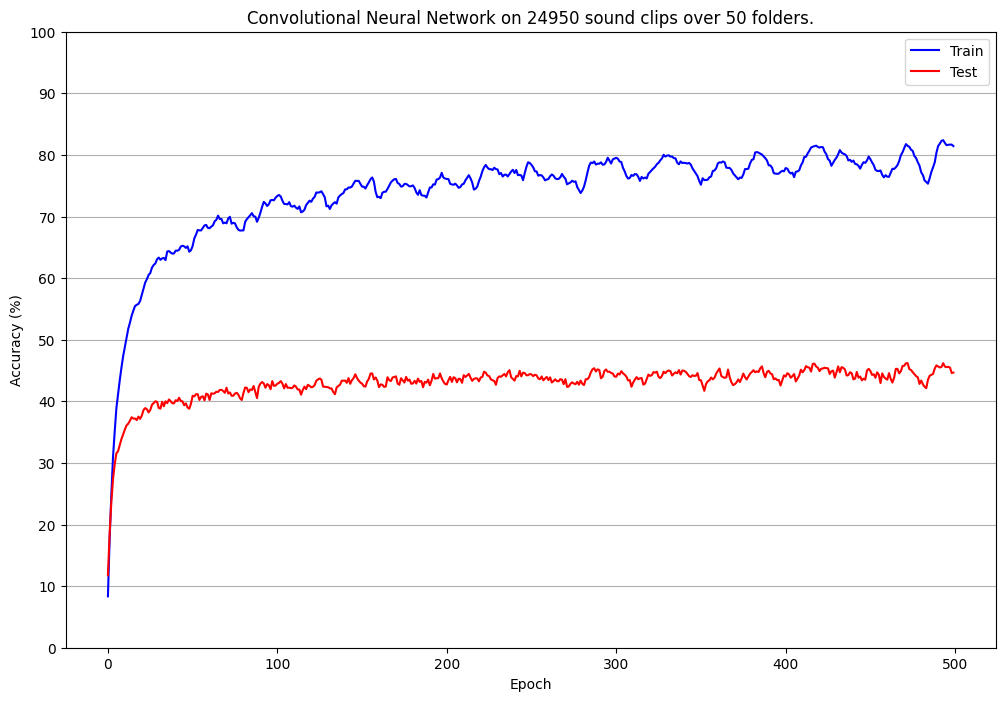

In [20]:
# to avoid extreme overfitting:
# - dropout rate between 0.2-0.5 seems good
# - learning rate around 0.001 provides best training rate without overfitting
# - train in larger batches, 64 upwards seems good
# - most seem to plateau around 200 epochs, maybe reduce to reduce total training time

reset_seed()

model = TestModel(input_shape=x_train.shape, dropout_rate=dropout_rate)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # since we are classifying.
loss_fn = loss_fn.to(device)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate) # adam has no momentum, but DOES have weight decay

train_loss_hist, train_acc_hist, test_acc_hist, best_model = train_model(model, loss_fn, optimizer, epochs, batch_size, save_best_to_file=True, experimental=experimental)

In [21]:
# final results after testing approx. 30 different variations of dropout, learning rate, etc
# best learning rate = 0.001, batch size of 32/64, dropout rate around 0.2-0.5
# 200 epochs gives best results as test acc plateaus after that, prevents overfitting
# train/test split between 20-30% gives good results

In [22]:
# investigate TOP 5 ERROR of the model.
# compare with top 1 error (accuracy)

model.load_state_dict(best_model)
model.eval()

# get predictions for ALL testing data
k = 5
test_pred = model(x_test)
test_pred_top_k = torch.topk(test_pred, k=k, dim=1)[1]

total = 0
in_top_k = 0
for index, value in enumerate(y_test):
    if value in test_pred_top_k[index]: in_top_k += 1

    total += 1

top_k_accuracy = in_top_k * 100 / total

print(f"Top {k} Accuracy: {top_k_accuracy:.03f}%")

Top 5 Accuracy: 65.932%


In [23]:
folder_df["file"].value_counts()

file
XC416747.mp3    225
XC350953.ogg    189
XC352051.ogg    168
XC552106.ogg    168
XC601771.ogg    155
               ... 
XC384434.ogg      1
XC423913.ogg      1
XC790247.ogg      1
XC334159.ogg      1
XC538254.ogg      1
Name: count, Length: 2014, dtype: int64

In [24]:
accuracy_df = pd.DataFrame(data=[y_test.cpu().numpy(), test_pred_top_k.cpu().numpy()], index=["actual", "pred"]).transpose()
accuracy_df["in_top_5"] = [1 if accuracy_df.iloc[i, 0] in accuracy_df.iloc[i, 1] else 0 for i in range(len(accuracy_df.index))]
folder_top_5 = accuracy_df.groupby(by="actual").aggregate(func=np.sum)["in_top_5"].values
folder_counts = accuracy_df.groupby(by="actual").aggregate(func=np.size)["in_top_5"].values
accuracy_df = pd.DataFrame(data=[folder_top_5, folder_counts], index=["in_top_5", "count"]).transpose()
accuracy_df["top_5_accuracy"] = round(accuracy_df["in_top_5"] * 100 / accuracy_df["count"], 2)
accuracy_df.sort_values(by="top_5_accuracy")

,in_top_5,count,top_5_accuracy
15,27,101,26.73
27,47,109,43.12
22,47,108,43.52
17,47,99,47.47
42,47,98,47.96
25,48,99,48.48
18,50,100,50.00
4,53,104,50.96
48,57,111,51.35
40,51,98,52.04
